## Value Function Approximation
### Two steps
- Define an objective function
- Derive algorithms optimizing the objective function

### Objective Function
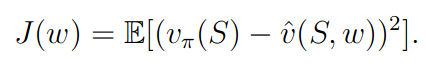
Note that, $S$ is a random variable, which have a probability distribution. So that the objective function can be interpreted as the **average approximation error over all states**.

### State distribution
- Even distribution
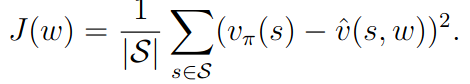
That is to treat all the states to be equally important.However, the importance of some states may be less than others. For example, some states may be rarely visited by a policy. Therefore, this way does not consider the real dynamics of the Markov process under the given policy.
- Stationary distribution
In short, it describes the long-run behavior of a Markov process.
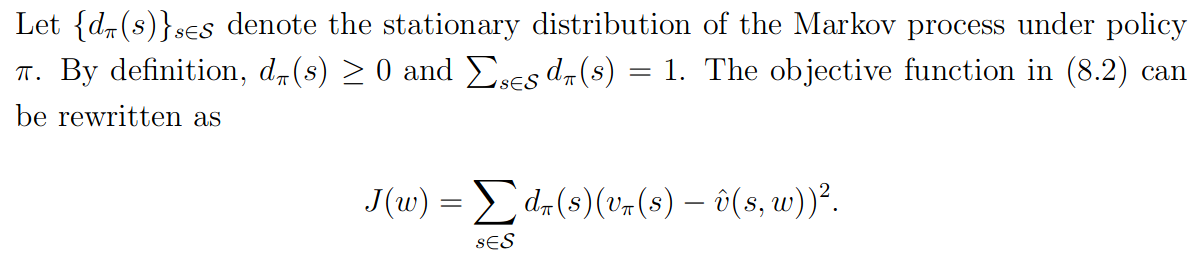
### Question
1. The relationship between stationary distribution with state transition matrix?
2. Under what conditions do stationary distribution exist?
    - the agent starting from an arbitrary state can always reach any other states within a finite number of steps.
3. What kind of policies can lead to stationary distribution?
    - exploration policy such as e-greedy policy

### Optimization algorithms
gradient-descent
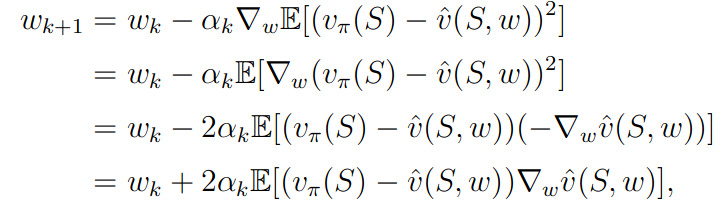

Use stochastic gradient descendent
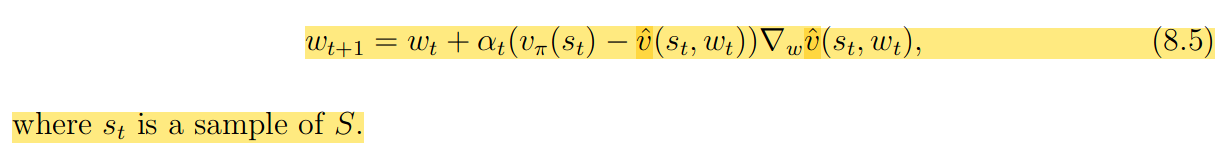
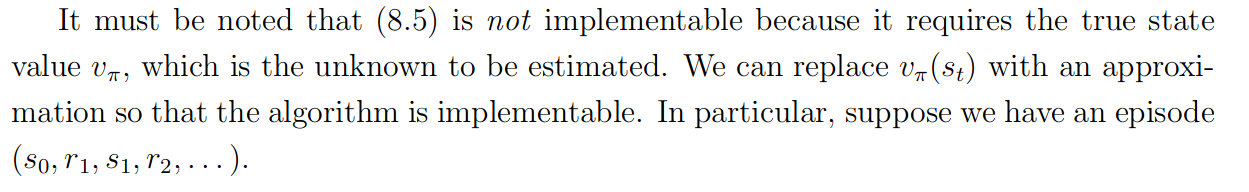

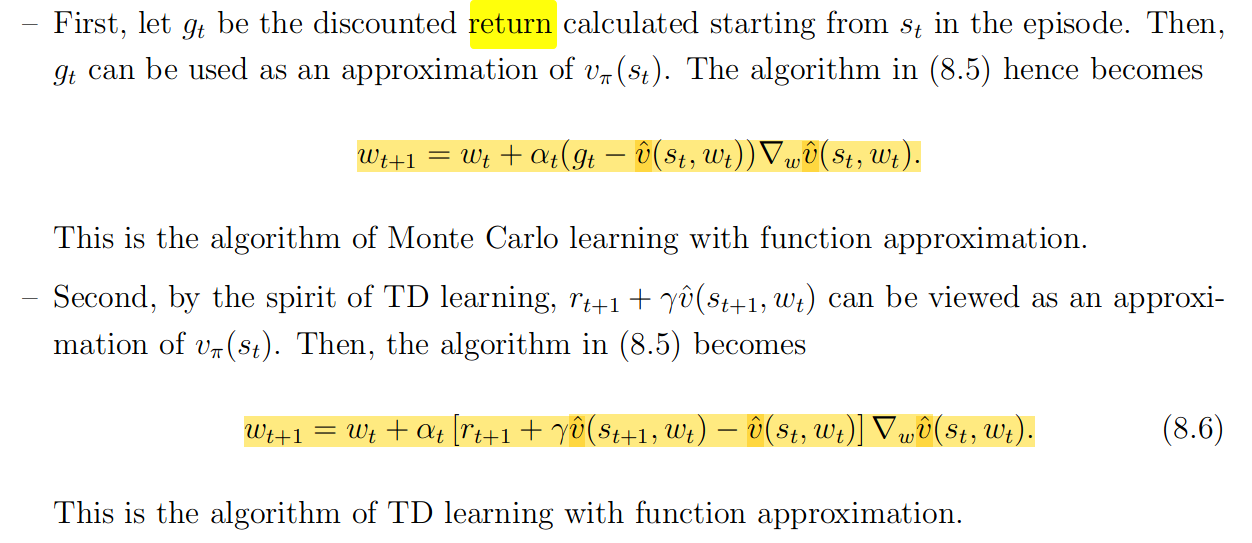

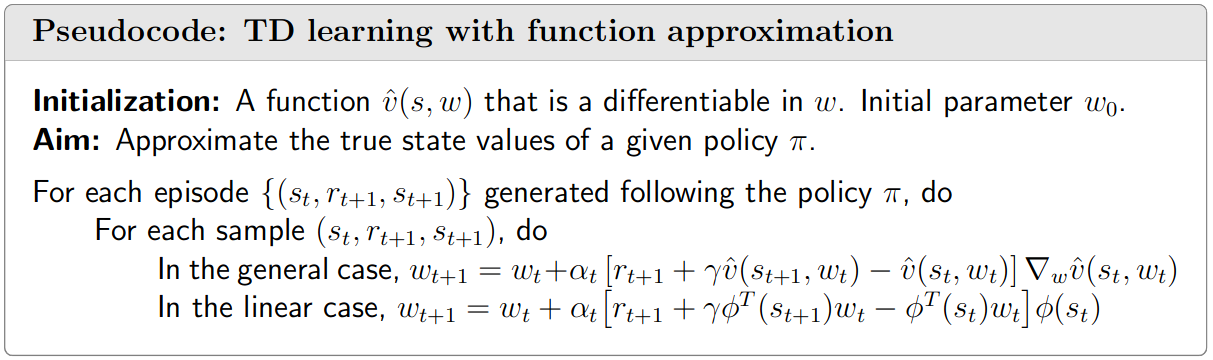

### Linear function approximation

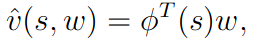
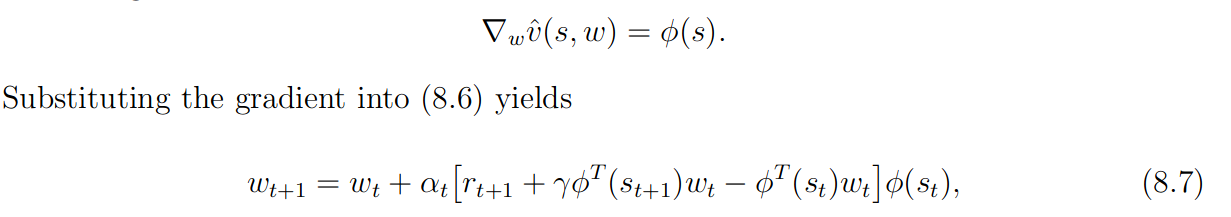

**Why study linear function approximators while nonlinear neural networks are widly used nowadays?**
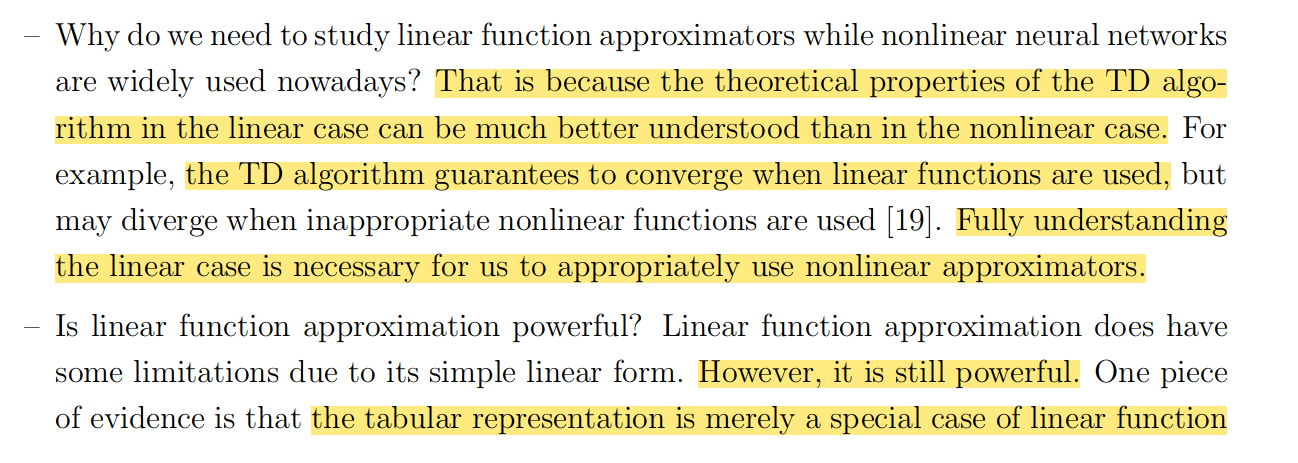
Very interesting!!
TD-tabluar learning can be writen as another form using linear approximation!!! P163

Approximation Error
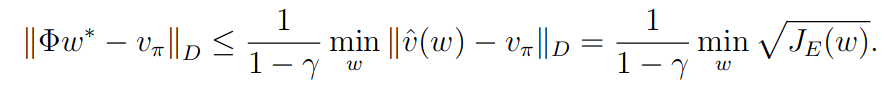

### Least-squares TD
An algorithm called least-squares TD (LSTD) [26]. It is another algorithm that minimizes the projected Bellman error.
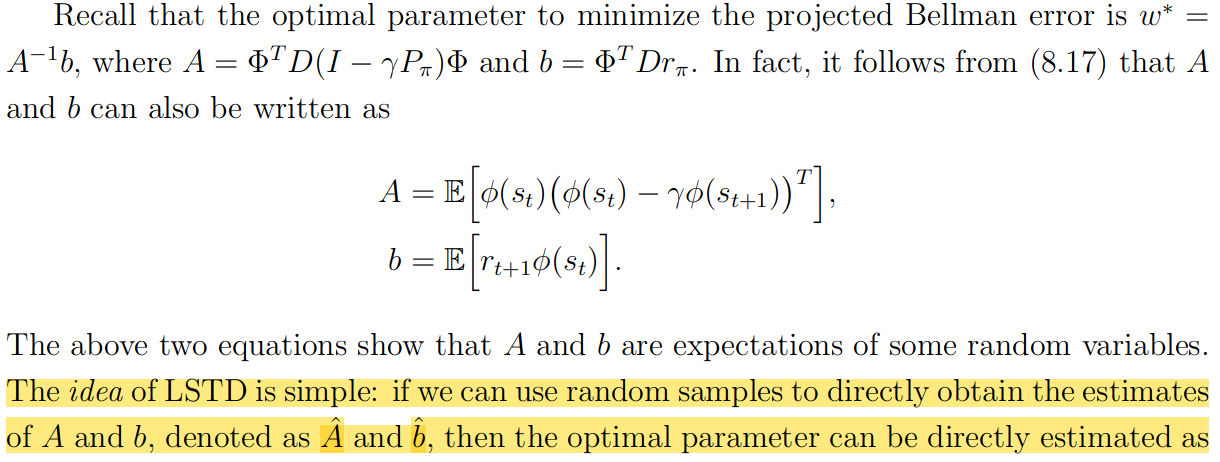
The **advantage** of LSTD is that it uses experience samples more efficiently and converges faster than the purely TD method.Why is that? It is simply because this algorithm is specifically designed based on the expression of the optimal solution. The better we understand a problem, the better algorithms we usually can design.

The **disadvantages** of LSTD are as follows. First, it can only estimate the state values and it is merely applicable to the linear case. While the TD algorithm can be extended to estimating action values as shown in the next section, LSTD can not. Moreover, while the TD algorithm allows nonlinear approximators, LSTD does not. That is because this algorithm is designed specifically based on the expression of w∗. Second, it is the computational cost of LSTD is higher than TD at each update step since LSTD updates an m × m matrix whereas TD updates an m-dimensional vector.

Saras with function approximation with the Linear Fourier function bases of order 5 are used.
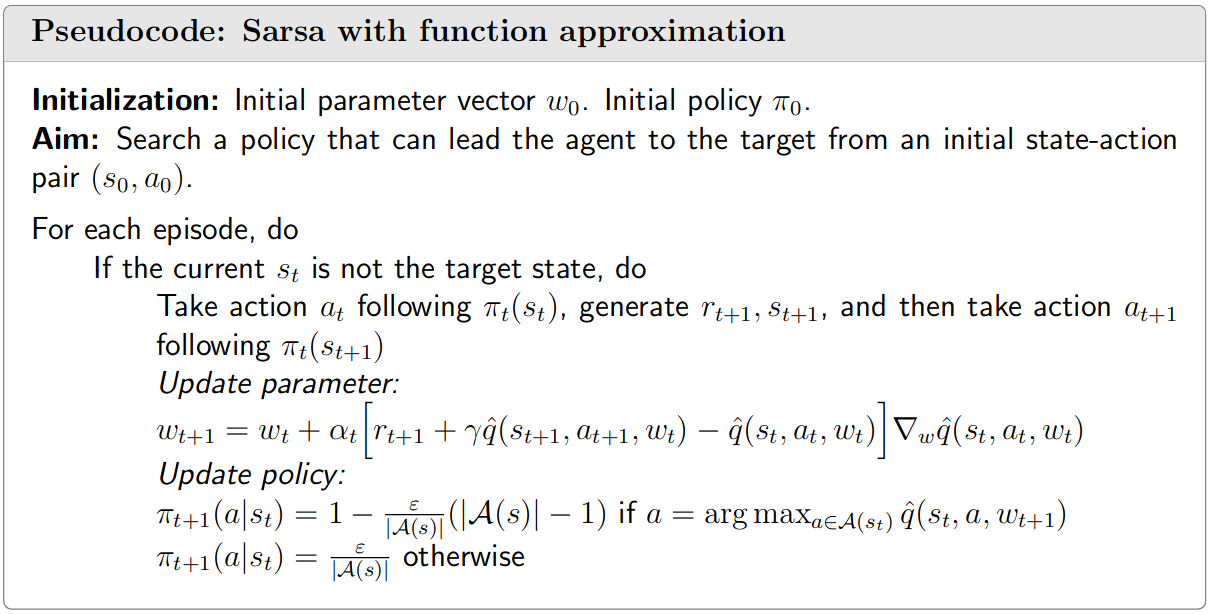

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from math import cos, pi
from itertools import product

In [2]:
def evaluate_policy(env, agent):
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    terminated = False
    sum_reward = 0
    for _ in range(cfg_params["max_episode_steps"]):
        a_k = agent.optimal_action(s_k)
        s_k1, r_k, terminated, _ , info = env.step(a_k)
        sum_reward += r_k
        s_k = s_k1
        if terminated:
            break
    return sum_reward
    

In [3]:
class LinearModel():
    def __init__(self, q_num):
        self.q_num = q_num  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def val(self, s_k, a_k):
        return np.dot(self.grad(s_k, a_k), self.omega) 
        
    def grad(self, s_k, a_k):
        # normalize
        normal_sk = s_k/15
        normal_ak = a_k/3
        
        return np.array([cos(pi*(x[0]*normal_sk + x[1]*normal_ak)) for x in list(product(range(self.q_num), repeat=2))])

    def pprint(self):
        pprint([[round(self.val(i, j),3) for j in range(4)] for i in range(16)])

    
class QValueModel(LinearModel):
    def __init__(self, q_num):
        super().__init__(q_num)

In [10]:
class Agent():
    def __init__(self, action_dim: int, state_dim: int, alpha=0.01, gamma=0.9, epsilon=0.1):
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_num = 7  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def Q(self, sk, ak) -> float:
        return np.dot(self.grad_Q(sk, ak), self.omega)
    
    def grad_Q(self, sk, ak):
        # normalize sk, ak
#         col = sk % 4
#         row = (sk - col)
#         normal_col = col / 3
#         normal_row = row / 3   
        normal_sk = sk / 15
        normal_ak = ak / 3
        
#         return np.array([cos(pi*(x[0]*normal_col + x[1]*normal_row + x[2]*normal_ak)) for x in list(product(range(self.q_num), repeat=3))])
        return np.array([cos(pi*(x[0]*normal_sk + x[1]*normal_ak)) for x in list(product(range(self.q_num), repeat=2))])

    def select_action(self, s_k: int) -> int:
        '''use e-greedy policy'''
        self.optimal_action
        if np.random.uniform(0, 1) > self.epsilon:
            a_k = self.optimal_action(s_k)
        else:
            a_k = np.random.choice(self.action_dim)
        return a_k
    
    def optimal_action(self, s_k: int) -> int:
        Q_sk = [self.Q(s_k, a_k) for a_k in range(4)]
        optimal_action_list = np.where(Q_sk == np.max(Q_sk))[0]
        return np.random.choice(optimal_action_list)
    
    def other_action(self, s_k: int) -> int:
        Q_sk = [self.Q(s_k, a_k) for a_k in range(4)]
        other_action_list = np.where(Q_sk != np.max(Q_sk))[0]
        return np.random.choice(other_action_list)
    
    def train(self, s_k, a_k, r_k, s_k1):
        # policy evaluation
        target_Q = r_k + self.gamma * np.max([self.Q(s_k1, i) for i in range(4)]) # Q learning
#         target_Q = r_k + self.gamma*self.Q(s_k1, self.select_action(s_k1))  # saras
        self.omega += self.alpha*(target_Q - self.Q(s_k, a_k))*self.grad_Q(s_k, a_k)
#         print(self.Q[s_k, a_k])

        

In [11]:
# parameter
cfg_params = {
    "env_name" : "FrozenLake-v1",
    "random_seed": 0,
    "max_train_steps": 2000,
    "max_episode_steps": 500,
}

env = gym.make(cfg_params["env_name"], desc=None, map_name="4x4", is_slippery=False) #  gym.make("CliffWalking-v0", render_mode="human")


In [12]:
# make it as a funtion for data analysis

agent = Agent(
    action_dim=env.action_space.n,
    state_dim=env.observation_space.n,
    alpha=0.01,  # 这个训练参数很重要，梯度下降的步长参数，太大，参数就会发散掉，不会收敛
    gamma=0.9,
    epsilon=0.01)

# training
score_queue = []

for k in range(cfg_params["max_train_steps"]):
    # reset t  he s_k
    data_queue = []
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    # collect data set
    for ek in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, truncated, info = env.step(a_k)
        agent.train(s_k, a_k, r_k, s_k1)
        if terminated:
#             print(f"s_k: {s_k}, s_k1: {s_k1}, r_k: {r_k}, a_k: {a_k}, e_k : {ek}, terminated: {terminated}")
            break
        
        s_k = s_k1
                
    score = evaluate_policy(env, agent)
    score_queue.append(score)
    print(f'current step: {k}/{cfg_params["max_train_steps"]}, score: {score}')


current step: 0/2000, score: 0.0
current step: 1/2000, score: 0.0
current step: 2/2000, score: 0.0
current step: 3/2000, score: 0.0
current step: 4/2000, score: 0.0
current step: 5/2000, score: 0.0
current step: 6/2000, score: 0.0
current step: 7/2000, score: 0.0
current step: 8/2000, score: 0.0
current step: 9/2000, score: 0.0
current step: 10/2000, score: 0.0
current step: 11/2000, score: 0.0
current step: 12/2000, score: 0.0
current step: 13/2000, score: 0.0
current step: 14/2000, score: 0.0
current step: 15/2000, score: 0.0
current step: 16/2000, score: 0.0
current step: 17/2000, score: 0.0
current step: 18/2000, score: 0.0
current step: 19/2000, score: 0.0
current step: 20/2000, score: 0.0
current step: 21/2000, score: 0.0
current step: 22/2000, score: 0.0
current step: 23/2000, score: 0.0
current step: 24/2000, score: 0.0
current step: 25/2000, score: 0.0
current step: 26/2000, score: 0.0
current step: 27/2000, score: 0.0
current step: 28/2000, score: 0.0
current step: 29/2000, s

current step: 258/2000, score: 0.0
current step: 259/2000, score: 0.0
current step: 260/2000, score: 0.0
current step: 261/2000, score: 0.0
current step: 262/2000, score: 0.0
current step: 263/2000, score: 0.0
current step: 264/2000, score: 0.0
current step: 265/2000, score: 0.0
current step: 266/2000, score: 0.0
current step: 267/2000, score: 0.0
current step: 268/2000, score: 0.0
current step: 269/2000, score: 0.0
current step: 270/2000, score: 0.0
current step: 271/2000, score: 0.0
current step: 272/2000, score: 0.0
current step: 273/2000, score: 0.0
current step: 274/2000, score: 0.0
current step: 275/2000, score: 0.0
current step: 276/2000, score: 0.0
current step: 277/2000, score: 0.0
current step: 278/2000, score: 0.0
current step: 279/2000, score: 0.0
current step: 280/2000, score: 0.0
current step: 281/2000, score: 0.0
current step: 282/2000, score: 0.0
current step: 283/2000, score: 0.0
current step: 284/2000, score: 0.0
current step: 285/2000, score: 0.0
current step: 286/20

current step: 501/2000, score: 0.0
current step: 502/2000, score: 0.0
current step: 503/2000, score: 0.0
current step: 504/2000, score: 0.0
current step: 505/2000, score: 0.0
current step: 506/2000, score: 0.0
current step: 507/2000, score: 0.0
current step: 508/2000, score: 0.0
current step: 509/2000, score: 0.0
current step: 510/2000, score: 0.0
current step: 511/2000, score: 0.0
current step: 512/2000, score: 0.0
current step: 513/2000, score: 0.0
current step: 514/2000, score: 0.0
current step: 515/2000, score: 0.0
current step: 516/2000, score: 0.0
current step: 517/2000, score: 0.0
current step: 518/2000, score: 0.0
current step: 519/2000, score: 0.0
current step: 520/2000, score: 0.0
current step: 521/2000, score: 0.0
current step: 522/2000, score: 0.0
current step: 523/2000, score: 0.0
current step: 524/2000, score: 0.0
current step: 525/2000, score: 0.0
current step: 526/2000, score: 0.0
current step: 527/2000, score: 0.0
current step: 528/2000, score: 0.0
current step: 529/20

current step: 967/2000, score: 0.0
current step: 968/2000, score: 0.0
current step: 969/2000, score: 0.0
current step: 970/2000, score: 0.0
current step: 971/2000, score: 0.0
current step: 972/2000, score: 0.0
current step: 973/2000, score: 0.0
current step: 974/2000, score: 0.0
current step: 975/2000, score: 0.0
current step: 976/2000, score: 0.0
current step: 977/2000, score: 0.0
current step: 978/2000, score: 0.0
current step: 979/2000, score: 0.0
current step: 980/2000, score: 0.0
current step: 981/2000, score: 0.0
current step: 982/2000, score: 0.0
current step: 983/2000, score: 0.0
current step: 984/2000, score: 0.0
current step: 985/2000, score: 0.0
current step: 986/2000, score: 0.0
current step: 987/2000, score: 0.0
current step: 988/2000, score: 0.0
current step: 989/2000, score: 0.0
current step: 990/2000, score: 0.0
current step: 991/2000, score: 0.0
current step: 992/2000, score: 0.0
current step: 993/2000, score: 0.0
current step: 994/2000, score: 0.0
current step: 995/20

current step: 1217/2000, score: 0.0
current step: 1218/2000, score: 0.0
current step: 1219/2000, score: 0.0
current step: 1220/2000, score: 0.0
current step: 1221/2000, score: 0.0
current step: 1222/2000, score: 0.0
current step: 1223/2000, score: 0.0
current step: 1224/2000, score: 0.0
current step: 1225/2000, score: 0.0
current step: 1226/2000, score: 0.0
current step: 1227/2000, score: 0.0
current step: 1228/2000, score: 0.0
current step: 1229/2000, score: 0.0
current step: 1230/2000, score: 0.0
current step: 1231/2000, score: 0.0
current step: 1232/2000, score: 0.0
current step: 1233/2000, score: 0.0
current step: 1234/2000, score: 0.0
current step: 1235/2000, score: 0.0
current step: 1236/2000, score: 0.0
current step: 1237/2000, score: 0.0
current step: 1238/2000, score: 0.0
current step: 1239/2000, score: 0.0
current step: 1240/2000, score: 0.0
current step: 1241/2000, score: 0.0
current step: 1242/2000, score: 0.0
current step: 1243/2000, score: 0.0
current step: 1244/2000, sco

current step: 1664/2000, score: 0.0
current step: 1665/2000, score: 0.0
current step: 1666/2000, score: 0.0
current step: 1667/2000, score: 0.0
current step: 1668/2000, score: 0.0
current step: 1669/2000, score: 0.0
current step: 1670/2000, score: 0.0
current step: 1671/2000, score: 0.0
current step: 1672/2000, score: 0.0
current step: 1673/2000, score: 0.0
current step: 1674/2000, score: 0.0
current step: 1675/2000, score: 0.0
current step: 1676/2000, score: 0.0
current step: 1677/2000, score: 0.0
current step: 1678/2000, score: 0.0
current step: 1679/2000, score: 0.0
current step: 1680/2000, score: 0.0
current step: 1681/2000, score: 0.0
current step: 1682/2000, score: 0.0
current step: 1683/2000, score: 0.0
current step: 1684/2000, score: 0.0
current step: 1685/2000, score: 0.0
current step: 1686/2000, score: 0.0
current step: 1687/2000, score: 0.0
current step: 1688/2000, score: 0.0
current step: 1689/2000, score: 0.0
current step: 1690/2000, score: 0.0
current step: 1691/2000, sco

current step: 1900/2000, score: 0.0
current step: 1901/2000, score: 0.0
current step: 1902/2000, score: 0.0
current step: 1903/2000, score: 0.0
current step: 1904/2000, score: 0.0
current step: 1905/2000, score: 0.0
current step: 1906/2000, score: 0.0
current step: 1907/2000, score: 0.0
current step: 1908/2000, score: 0.0
current step: 1909/2000, score: 0.0
current step: 1910/2000, score: 0.0
current step: 1911/2000, score: 0.0
current step: 1912/2000, score: 0.0
current step: 1913/2000, score: 0.0
current step: 1914/2000, score: 0.0
current step: 1915/2000, score: 0.0
current step: 1916/2000, score: 0.0
current step: 1917/2000, score: 0.0
current step: 1918/2000, score: 0.0
current step: 1919/2000, score: 0.0
current step: 1920/2000, score: 0.0
current step: 1921/2000, score: 0.0
current step: 1922/2000, score: 0.0
current step: 1923/2000, score: 0.0
current step: 1924/2000, score: 0.0
current step: 1925/2000, score: 0.0
current step: 1926/2000, score: 0.0
current step: 1927/2000, sco

In [182]:
evaluate_env = gym.make(cfg_params["env_name"], render_mode="human",desc=None, map_name="4x4", is_slippery=False)
evaluate_policy(evaluate_env, agent)

1.0

In [181]:
[[round(agent.Q(j, i),2) for i in range(4)] for j in range(15)]

[[0.89, 1.63, 0.64, 0.54],
 [0.92, 1.14, 0.59, 0.57],
 [1.0, 1.02, 0.91, 0.6],
 [1.09, 1.46, 1.18, 0.59],
 [1.08, 1.8, 1.02, 0.51],
 [0.94, 1.4, 0.69, 0.43],
 [0.8, 0.63, 0.79, 0.47],
 [0.85, 0.49, 1.46, 0.71],
 [1.12, 1.3, 1.99, 1.0],
 [1.33, 2.21, 1.73, 1.1],
 [1.22, 2.23, 0.95, 0.89],
 [0.86, 1.46, 0.65, 0.54],
 [0.66, 0.91, 1.38, 0.41],
 [0.92, 1.18, 2.45, 0.67],
 [1.44, 1.76, 2.73, 1.11]]

下面这个是用表格方法做出的结果，下图机器人倾向于往右走。本策略更倾向于向下走。
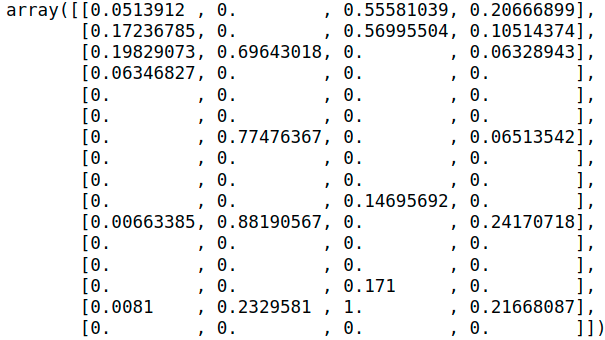